In [19]:
import requests, pandas as pd, numpy as np
import pickle
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import *
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [20]:
#Load Bitcoin Price History
with open('../crypto_currency_and_market_value_history/data/bitcoin_4_year_hourly_history_df.pickle', 'rb') as file:
     bitcoin_2_5_year_price_hist_df = pickle.load(file)

In [21]:
bitcoin_2_5_year_price_hist_df = bitcoin_2_5_year_price_hist_df[bitcoin_2_5_year_price_hist_df.timestamp > '2017-06-01 00:00:00']

In [22]:
#New Dataframe with timestamp set to index
indexed_df = bitcoin_2_5_year_price_hist_df.set_index('timestamp')

In [23]:
#assign market close data to variable for visual
time_series_bitcoin = indexed_df['close']

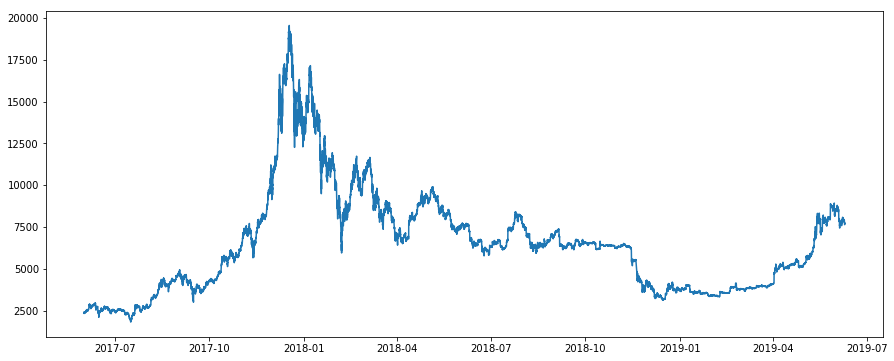

In [24]:
# visualize the time series to see how Bitcoin changes over time
plt.plot(time_series_bitcoin)

In [25]:
# resamply by week
time_series_bitcoin_week = time_series_bitcoin.resample('W').mean()

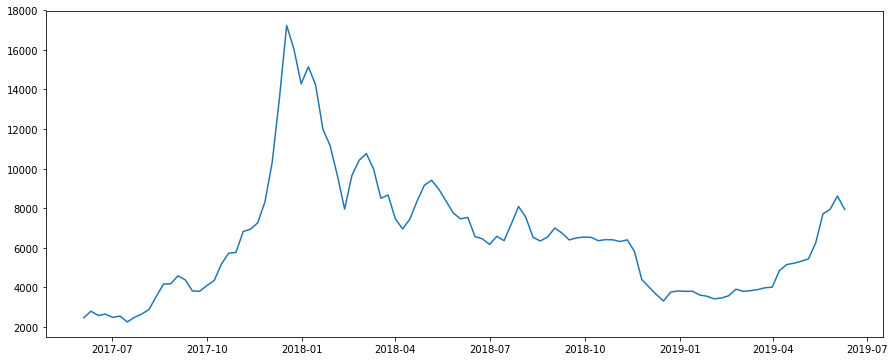

In [26]:
plt.plot(time_series_bitcoin_week)

In [39]:
# check for stationarity
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7,center=False).mean() 
    rolstd = timeseries.rolling(window=7,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

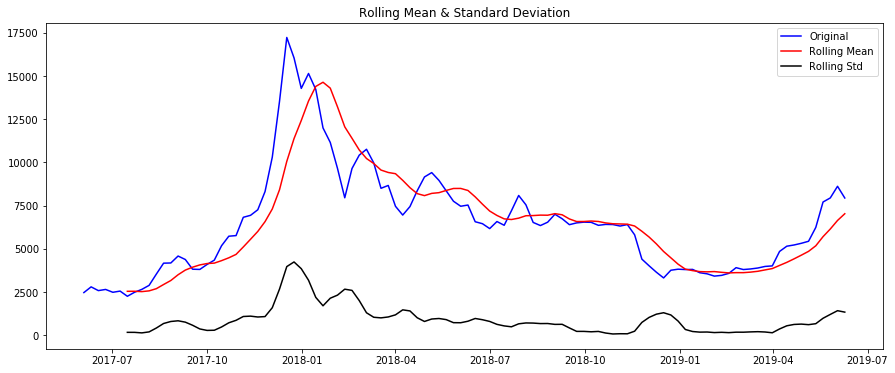

Results of Dickey-Fuller Test:
Test Statistic                  -2.114070
p-value                          0.238895
#Lags Used                       4.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [40]:
test_stationarity(time_series_bitcoin_week)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [29]:
# apply a non linear log transform
time_series_bitcoin_week_log = np.log(time_series_bitcoin_week)

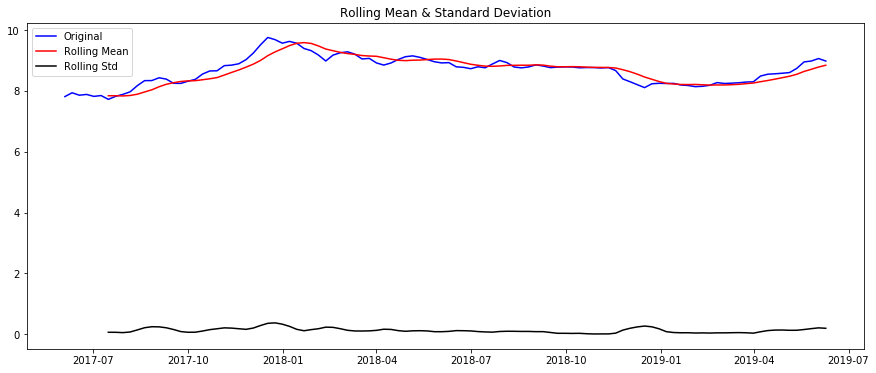

Results of Dickey-Fuller Test:
Test Statistic                  -1.959575
p-value                          0.304574
#Lags Used                       1.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [30]:
test_stationarity(time_series_bitcoin_week_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

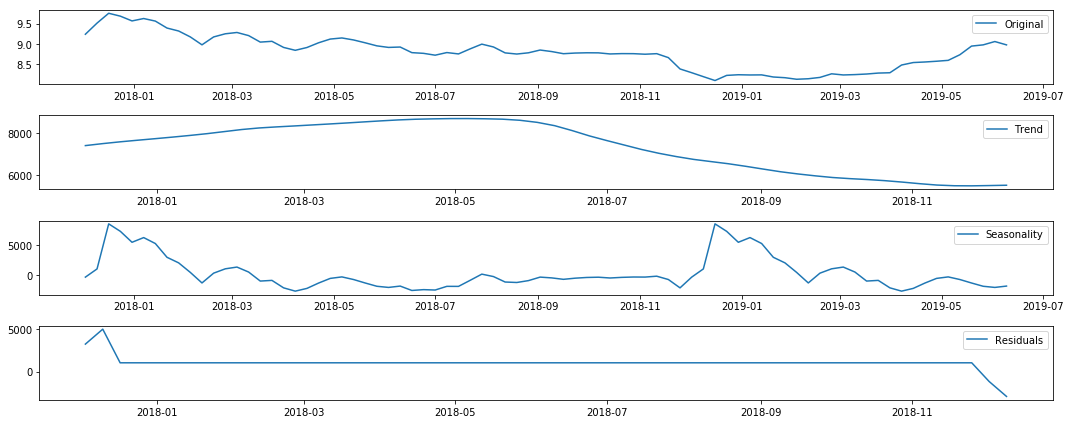

In [31]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(time_series_bitcoin_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(time_series_bitcoin_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

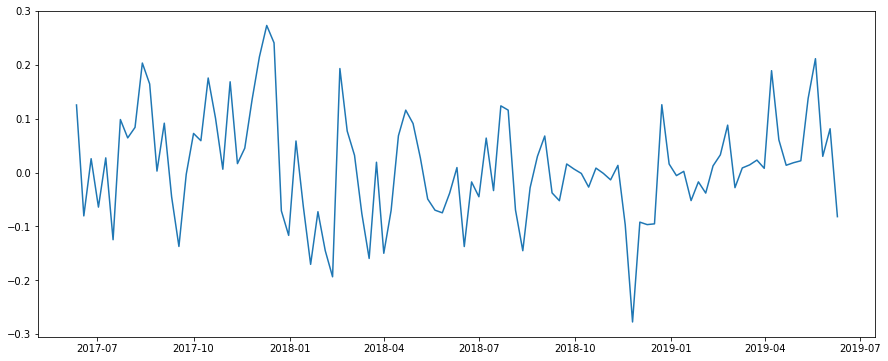

In [32]:
# remove trend and seasonality with differencing

time_series_bitcoin_week_log_diff = time_series_bitcoin_week_log - time_series_bitcoin_week_log.shift()
plt.plot(time_series_bitcoin_week_log_diff)

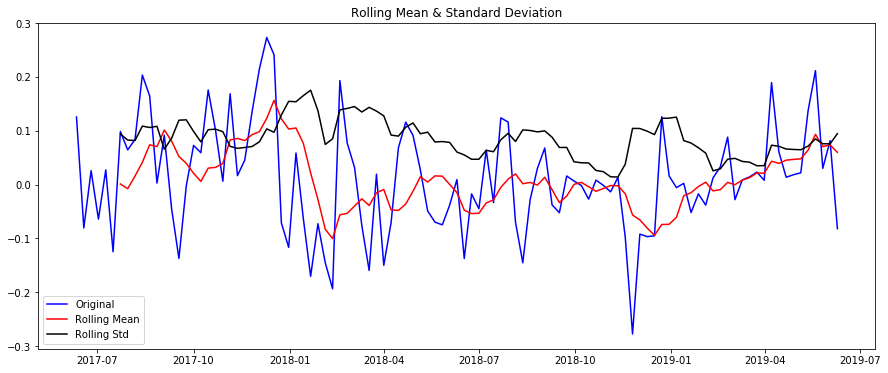

Results of Dickey-Fuller Test:
Test Statistic                -6.710806e+00
p-value                        3.684921e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.040000e+02
Critical Value (1%)           -3.494850e+00
Critical Value (5%)           -2.889758e+00
Critical Value (10%)          -2.581822e+00
dtype: float64


In [33]:
time_series_bitcoin_week_log_diff.dropna(inplace=True)
test_stationarity(time_series_bitcoin_week_log_diff)

In [34]:
size = int(len(time_series_bitcoin_week_log)*(0.7))
train, test = time_series_bitcoin_week_log[0:size], time_series_bitcoin_week_log[size:len(time_series_bitcoin_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=6462.515362, expected=6319.384107
predicted=6336.278500, expected=6404.512262
predicted=6496.258739, expected=5812.538393
predicted=5634.189528, expected=4404.775417


C:\Users\moham\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=3952.439799, expected=4017.735238
predicted=3892.797732, expected=3647.854881
predicted=3514.909709, expected=3316.768155
predicted=3199.068963, expected=3762.164167
predicted=3977.274247, expected=3822.528155
predicted=3848.869677, expected=3801.165476
predicted=3817.065245, expected=3809.890595
predicted=3819.280064, expected=3616.882083
predicted=3559.244134, expected=3555.053214
predicted=3541.216279, expected=3422.260179
predicted=3380.697458, expected=3465.039048
predicted=3495.696040, expected=3580.978333
predicted=3637.038017, expected=3910.736190
predicted=4070.447393, expected=3802.802917
predicted=3762.617778, expected=3835.661667
predicted=3874.957623, expected=3890.751071
predicted=3914.334775, expected=3982.010000
predicted=4044.517199, expected=4013.667024
predicted=4029.301502, expected=4849.633393
predicted=5262.926176, expected=5153.239702
predicted=5312.380771, expected=5223.712560
predicted=5268.808272, expected=5320.315417
predicted=5396.570257, expected=

In [35]:
predictions_series = pd.Series(predictions, index = test.index)

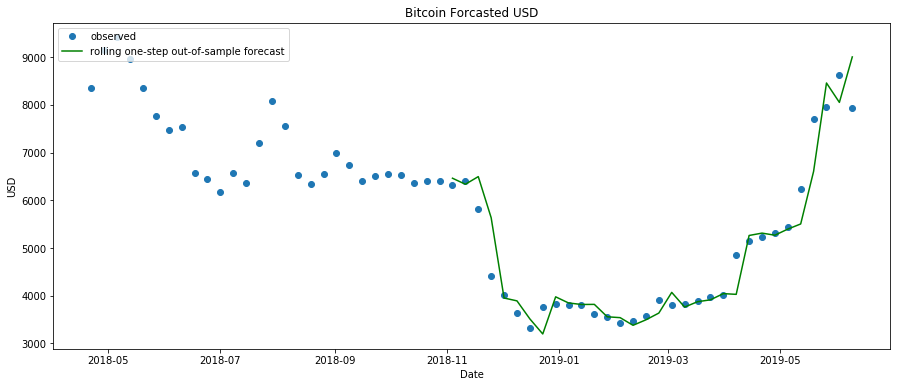

In [36]:
fig, ax = plt.subplots()
ax.set(title='Bitcoin Forcasted USD', xlabel='Date', ylabel='USD')
ax.plot(time_series_bitcoin_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')